# Выделение групп пользователей на основе поведения в мобильном приложении "Ненужные вещи"

Цель исследования:
<br> В датасете данные, совершенные в мобильном приложении "Ненужные вещи".
<br> Нужно определить целевую аудиторию:
1. Какие пользователи чаще других возвращаются в мобильное приложение. 
2. Какие пользователи часто совершают целевое событие.

Задачи исследования:
1. Провести исследовательский анализ. В нем исследовать:
- пользователей
- события
- источники
- выделить пользовательские сессии и исследовать их
2. Кластеризовать пользователей:
- выбрать и рассчитать метрики
- построить дендрограмму и узнать число кластеров
- разделить пользователей алгоритмом K-Means
3. Описать каждую группу пользователей
- сравнить характеристики и метрики, найти целевую аудиторию
4. Выдвинуть гипотезы и проверить их стат тестом
5. Написать общий вывод

## Импорт библиотек

In [1]:
import pandas as pd

import numpy as np

import plotly.express as px
import plotly.graph_objects as go

from matplotlib import pyplot as plt

import datetime as dt

import seaborn as sns

from datetime import timedelta

from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage 

import itertools

import warnings
warnings.filterwarnings('ignore')

from functools import reduce

import math as mth

from scipy import stats as st

## Функции

In [2]:
def general_info(df):
    display(df.head())
    print('Общая информация:')
    print(df.info())
    print('В таблице {} столбцов и {} строк'.format(df.shape[1], df.shape[0]))
    print('Kоличество пропусков:')
    omssns = df.isna().sum()
    omissions = pd.DataFrame(data={'column': omssns.index, 
                                   'omissions': [x for x in omssns],
                                   '%-omissions': ['{:.2%}'.format(x/df.shape[0]) for x in omssns]})
    display(omissions.sort_values(by='omissions', ascending=False))
    print('Kоличество явных дубликатов:', df.duplicated().sum())

In [3]:
# функция для построения barplot
def df_bar(df, col_gr, col, func='count', tit='События'):
    plt.figure(figsize=(15, 7))
    df_f = df.groupby([col_gr], as_index=False)\
             .agg({col: func})\
             .sort_values(by=col, ascending=False)
    df_f['per'] = df_f[col].map(lambda r: str(r) +' - '+ '{:.2%}'.format(r/(df_f[col].sum())))
    b = sns.barplot(data=df_f, y=col, x=col_gr)
    for p in b.patches:
        b.annotate('{:.0f} - {:.0%}'.format(p.get_height(), p.get_height()/df_f[col].sum()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    plt.title(tit)
    plt.show()

In [4]:
# функция для построения barplot
def df_bar_source(df, tit='События по источникам'):
    df_f = df.groupby(['source', 'event_name'], as_index=False)\
             .agg({'user_id': 'count'})
    #fig = go.Figure()
    plt.figure(figsize=(15, 7))
    b = sns.barplot(data=df_f, y='user_id', x='event_name', hue='source')
    for p in b.patches:
        b.annotate('{:.0f}'.format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
        
        
    plt.title(tit)
    plt.show()

In [5]:
# функция для построения воронки
def df_funnel(df, func='nunique', tit='Воронка событий'):
    df_f = df.groupby(['ru_event_name'], as_index=False)\
             .agg({'user_id': func})\
             .sort_values(by='ru_event_name')
    df_f['per'] = df_f['user_id'].map(lambda r: str(r) +' - '+ '100%' if r==df_f['user_id'].max() 
                                      else str(r) +' - '+ '{:.0%}'.format(r/df_f['user_id'].max()))
                                      
    x_max = df_f.user_id.max()
    x_min = 0
    x_range = x_max - x_min
    plt.figure(figsize=(15, 7))
    for idx in df_f.index:
        left = (x_range - df_f.loc[idx, 'user_id'])/2
        plt.barh(idx, df_f.loc[idx, 'user_id'], left = left, color='lightblue',
             height=.8, edgecolor='black')
        # label
        plt.text(x_max/2, idx, df_f.loc[idx, 'ru_event_name'], ha='center', 
             fontsize=12, color='#2A2A2A')
        # value
        plt.text(x_max/2, idx-0.2, df_f.loc[idx, 'per'], ha='center',
             fontsize=12, color='#2A2A2A')
    plt.yticks([0, 1])
    plt.title(tit)
    plt.show()

In [6]:
# функция для построения воронки по каналам
def df_funnel_source(df, func='nunique', tit='Воронка событий'):
    df_f = df.groupby(['source', 'ru_event_name'], as_index=False)\
             .agg({'user_id': func})\
             .sort_values(by='user_id', ascending=False)
    
    a = df_f.query('source=="other"')
    b = df_f.query('source=="yandex"')
    c = df_f.query('source=="google"')
    
    dict_source = {'other': a, 'yandex': b, 'google': c}
    
       
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, name in enumerate(dict_source):
        df_s = dict_source[name]
        
        x_max = df_s.user_id.max()
        x_min = 0
        x_range = x_max - x_min
        
        df_s['per'] = df_s['user_id'].map(lambda r: str(r) +' - '+ '100%' if r==df_s['user_id'].max() 
                                      else str(r) +' - '+ '{:.0%}'.format(r/df_s['user_id'].max()))
        
        ax = axes[i]
        
        ttl = tit+' для '+name 
        for idx in df_s.index:
            left = (x_range - df_s.loc[idx, 'user_id'])/2
            ax.barh(idx, df_s.loc[idx, 'user_id'], left = left, color='lightblue',
             height=.8, edgecolor='black')
            # label
            ax.text(x_max/2, idx, df_s.loc[idx, 'ru_event_name'], ha='center', 
             fontsize=12, color='#2A2A2A')
            # value
            ax.text(x_max/2, idx-0.2, df_s.loc[idx, 'per'], ha='center',
             fontsize=12, color='#2A2A2A')
            ax.set_title(ttl)
    fig.tight_layout()
    fig.show()

In [7]:
def retention_rate(df):
    # таблица удержания без учета момента горизонта
    result_grouped = df.pivot_table(index=['first_date'], columns='lifetime', values='user_id', aggfunc='nunique')
    # размер когорт
    cohort_sizes = df.groupby('first_date').agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'})
    # объединяем размеры когорт и таблицу удержания
    result_grouped = cohort_sizes.merge(result_grouped, on='first_date', how='left').fillna(0)
    sum_ret_r = result_grouped.sum(axis=0)
    # делим данные таблицы удержания на размеры когорт
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0).round(2).drop(columns=['cohort_size'])
    sum_ret_r = sum_ret_r.div(sum_ret_r['cohort_size'], axis=0).round(2).drop(index=['cohort_size'])
    return result_grouped, sum_ret_r

In [8]:
def show_plot(rr_df):
    f, axes = plt.subplots(figsize=(15,10))
    rr_df.T.plot(grid=True, xticks=list(rr_df.columns.values), ax=axes)
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания по дням привлечения')
    plt.legend(loc='upper left')
    plt.show()

In [9]:
def show_heatmap(rr_df):
    f, axes = plt.subplots(figsize=(10,10))
    sns.heatmap(rr_df, annot=True, fmt='.2%', ax=axes)
    plt.title('Тепловая карта удержания')
    plt.show()

In [10]:
# функция, которая считает конверсию для выбранных источников и пары событий
def df_gf_ev(df, group, func, event_top, event_down):
    index = ['event_top', 'event_down', 'conversion']
    
    df_rez = pd.DataFrame()
    
    if group!=[]:
        for gr in group:
            for i in range(len(event_down)):
                
                e_down = event_down[i]
                e_top = event_top[i]
                # нахожу альтернативное событие, которое не должно быть у пользователей
                e_nt = [e for e  in event_top if e!=e_top]
                if e_nt!=[]:
                    # извлекаю альтернативное событие, которое не должно быть у пользователей
                    e_not = e_nt[0]
                    # получаем список пользователей, в котором у пользователей есть выбранное событие и нет альтернативного
                    # создаю список событий каждого пользователя
                    users_df = mobile_df.groupby('user_id', as_index=False).agg({'event_name': 'unique'})
                    # проверяю есть ли нужное событие в списке и отсутствует ли альтернативное
                    users_df['user_true'] = users_df['event_name'].map(lambda e: True if e_top in e and not e_not in e else False)
                    # выбираю этих пользователей
                    users = users_df.query('user_true').user_id
                else:
                    users=df.user_id.unique()
                    
                
                # получаю количество уникальных пользователей по событиям и источникам
                event_2 = df.query('event_name==@e_down & user_id.isin(@users) & source==@gr')\
                      .agg({'user_id': func}).user_id
                event_1 = df.query('event_name==@e_top & user_id.isin(@users) & source==@gr')\
                      .agg({'user_id': func}).user_id
                # создаю столбец с конверсией
                conversion = (event_2 / event_1).round(2)
                s = pd.Series(data=[event_1, event_2, conversion], index=index, name=str(gr)+':'+e_down+'/'+e_top)
                df_rez = df_rez.append(s)
            
    else:
        for i in range(len(event_down)):
                e_down = event_down[i]
                e_top = event_top[i]
                e_nt = [e for e in event_top if e!=e_top][0]
                if e_nt!=[]:
                    # извлекаю альтернативное событие, которое не должно быть у пользователей
                    e_not = e_nt[0]
                    # получаем список пользователей, в котором у пользователей есть выбранное событие и альтернативного
                    # создаю список событий каждого пользователя
                    users_df = mobile_df.groupby('user_id', as_index=False).agg({'event_name': 'unique'})
                    # проверяю есть ли нужное событие в списке и отсутствует ли альтернативное
                    users_df['user_true'] = users_df['event_name'].map(lambda e: True if e_top in e and not e_not in e else False)
                    # выбираю этих пользователей
                    users = users_df.query('user_true').user_id
                else:
                    users=df.user_id.unique()
                    
                # получаю количество уникальных пользователей по событиям
                event_2 = df.query('event_name==@e_down & user_id.isin(@users)')\
                      .agg({'user_id': func}).user_id
                event_1 = df.query('event_name==@e_top & user_id.isin(@users)')\
                      .agg({'user_id': func}).user_id
                # создаю столбец с конверсией
                conversion = (event_2 / event_1).round(2)
                s = pd.Series(data=[event_1, event_2, conversion], index=index, name=e_down+'/'+e_top)
                df_rez = df_rez.append(s)
    print('Таблица конверсии')
    display(df_rez)
    return df_rez

In [11]:
# функция, которая проводит z-тест для выбранных пар событий
def stat_group(df, alph):
           
    # z-тест
    alpha = alph
    
    # пропорция успехов в комбинированном датасете:
    p_combined = df.event_down.sum() / df.event_top.sum()
    # разница пропорций в датасетах
    difference = reduce(lambda x, y: x-y, df.conversion)
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (sum([1/x for x in df.event_top])))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    # Если бы конверсии были равны, разница между ними была бы равна нулю
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: {:.4f}'.format(p_value))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между конверсиями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать конверсии разными') 

In [12]:
# функция, которая проходит по уникальным значениям пар событий для заданных групп и проводит z-тест
def stat_rez(dt, group=[], dt_func='nunique', alpha=0.05, evnt_top=['tips_show'],
                       evnt_down=['show_contacts']):
    # прохожусь по событиям

    print()
    dt_gr = df_gf_ev(dt, group, dt_func, evnt_top, evnt_down)
    stat_group(dt_gr, alpha)

## Загрузка и изучение данных

In [13]:
try:
    mobile_dataset = pd.read_csv('/datasets/mobile_dataset.csv')
except:
     mobile_dataset = pd.read_csv('mobile_dataset.csv')

In [14]:
try:
    mobile_soures = pd.read_csv('/datasets/mobile_soures.csv')
except:
     mobile_soures = pd.read_csv('mobile_sourсes.csv')

### Таблица mobile_dataset

In [15]:
general_info(mobile_dataset)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB
None
В таблице 3 столбцов и 74197 строк
Kоличество пропусков:


,column,omissions,%-omissions
0,event.time,0,0.00%
1,event.name,0,0.00%
2,user.id,0,0.00%


Kоличество явных дубликатов: 0


Датасет mobile_dataset.csv содержит колонки:
- event.time  — время совершения
- event.name  — название события
- user.id  — идентификатор пользователя

В предобработке:
1. Перемеиную столбцы
2. Переведу дату в формат даты, округлю секунды, выделю столбец с датой без времени.
3. Заменю дубликаты в названиях событий.

### Таблица mobile_soures

In [16]:
general_info(mobile_soures)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB
None
В таблице 2 столбцов и 4293 строк
Kоличество пропусков:


,column,omissions,%-omissions
0,userId,0,0.00%
1,source,0,0.00%


Kоличество явных дубликатов: 0


Датасет mobile_sources.csv содержит колонки:
- userId — идентификатор пользователя
- source — источник, с которого пользователь установил приложение

В предобработке:
1. Перемеиную столбцы

## Предобработка данных

### Таблица mobile_dataset

#### Переименование столбцов

In [17]:
mobile_dataset = mobile_dataset.rename(columns={'event.time': 'event_time',
                                                 'event.name': 'event_name',
                                                  'user.id': 'user_id'})

#### Предобработка столбца с датой

In [18]:
# переведу дату в формат времени
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'], format='%Y-%m-%d %H:%M:%S')

In [19]:
# округлю до секунд
mobile_dataset['event_time'] = mobile_dataset['event_time'].astype('datetime64[s]')

In [20]:
# выделю столбец с датой
mobile_dataset['date'] = mobile_dataset['event_time'].dt.date

#### Предобработка столбца с событиями

Заменю дубликаты названий на один вариант

In [21]:
mobile_dataset['event_name'] = mobile_dataset['event_name'].replace('contacts_show', 'show_contacts')

In [22]:
for e in ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']:
    mobile_dataset['event_name'] = mobile_dataset['event_name'].replace(e, 'search')

Добавлю столбец с названиями событий на русском

In [23]:
dict_event_name = {'advert_open': 'открытие карточки объявления',
                   'photos_show': 'просмотр фотографий в объявлении',
                   'tips_show': 'пользователь увидел рекомендованные объявления',
                   'tips_click': 'пользователь кликнул по рекомендованному объявлению',
                   'show_contacts': 'пользователь нажал на кнопку "посмотреть номер"',
                   'map': 'пользователь открыл карту размещенных объявлений',
                   'search': 'событие, связанное с поиском по сайту',
                   'favorites_add': 'добавление объявления в избранное',
                   'contacts_call': 'пользователь позвонил по номеру телефона на карточке объявления'}

In [24]:
mobile_dataset['ru_event_name'] = mobile_dataset['event_name'].apply(lambda n: dict_event_name[n])

### Таблица mobile_soures

#### Переименование столбцов

In [25]:
mobile_soures = mobile_soures.rename(columns={'userId': 'user_id'})

### Объединение таблиц

In [26]:
mobile_df = mobile_dataset.merge(mobile_soures, on='user_id', how='outer')

In [27]:
mobile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   event_time     74197 non-null  datetime64[ns]
 1   event_name     74197 non-null  object        
 2   user_id        74197 non-null  object        
 3   date           74197 non-null  object        
 4   ru_event_name  74197 non-null  object        
 5   source         74197 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 4.0+ MB


Количество строк как у mobile_dataset, пропусков нет.

Данные готовы для исследования.

##  Исследовательский анализ данных

### Пользователи

#### Сколько уникальных пользователей

In [28]:
count_unique_user = mobile_df.user_id.nunique()
print('В приложении {} уникальных пользователей'.format(count_unique_user))

В приложении 4293 уникальных пользователей


### События

#### Сколько событий

In [29]:
print('В датасете {} событий'.format(mobile_df.event_name.nunique()))

В датасете 9 событий


#### Посмотреть как они соотносятся (barplot)

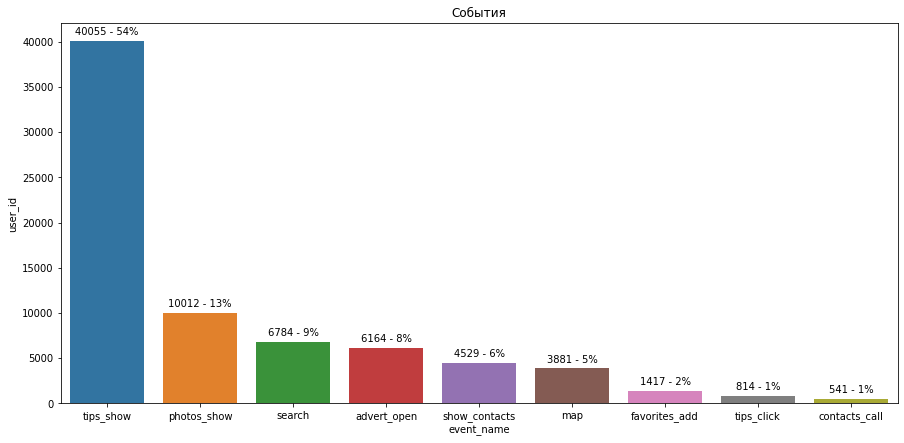

In [30]:
df_bar(mobile_df, 'event_name', 'user_id', func='count', tit='События')

Более 50% событий - пользователь увидел рекомендованное объявление.
<br> На целевое действие - просмотр контактов - приходится всего 6% событий.

#### Сколько событий в среднем на одного пользователя

In [31]:
event_mean = mobile_df.groupby(['user_id'], as_index=False).agg({'ru_event_name': 'count'}).ru_event_name.mean()
print('В среднем на пользователя приходится {:.0f} событий'.format(event_mean))

В среднем на пользователя приходится 17 событий


#### Сколько уникальных пользователей у каждого события

In [32]:
ev_gr_user = mobile_df.groupby('event_name', as_index=False).agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
ev_gr_user

,event_name,user_id
8,tips_show,2801
5,search,1666
3,map,1456
4,photos_show,1095
6,show_contacts,981
0,advert_open,751
2,favorites_add,351
7,tips_click,322
1,contacts_call,213


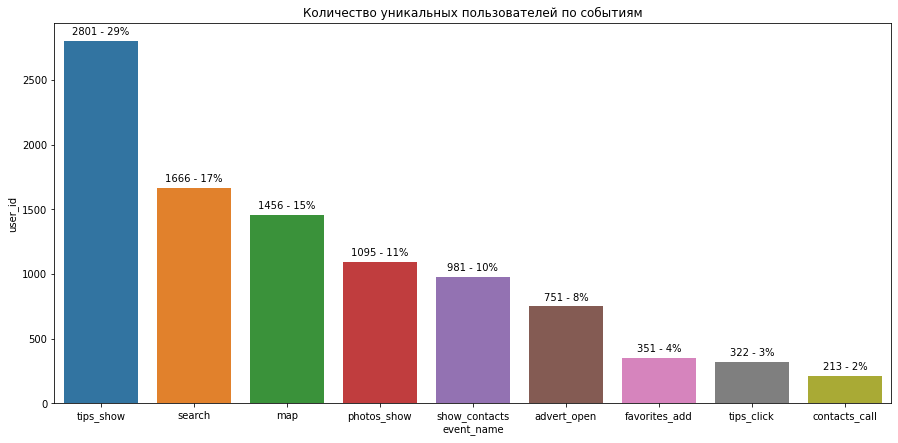

In [33]:
plt.figure(figsize=(15, 7))
b = sns.barplot(data=ev_gr_user, y='user_id', x='event_name')
for p in b.patches:
    b.annotate('{:.0f} - {:.0%}'.format(p.get_height(), p.get_height()/ev_gr_user['user_id'].sum()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.title('Количество уникальных пользователей по событиям')
plt.show()

По таблице видно, что не все пользователи видели рекомендованное объявление, некоторые воспользовались поиском, для нахождения объявления.
<br> Пыталась перебрать группы событий, чтобы найти 100% охват, но не подобрала.

#### Выделить ключевые события

Можно выделить группы событий:
1. tips_show и tips_click - рекомендации
2. search, map - поиск
3. photos_show, advert_open	- обзор объявлений
4. show_contacts, contacts_call	- общение с продавцом
5. favorites_add - дополнительные действия
<br>События 1 и 2 групп - первичные действия, которые могут привести к покупке
<br>События 4 группы - условная покупка. Поскольку не все пользователи посмотревшие контакты продавца, сразу позвонили, целевое действие - просмотр контактов.

#### Построить воронку событий по количеству уникальных пользователей

Поскольку нет цепочки событий, которую выполняли бы все пользователи, выделить события для воронки нельзя.

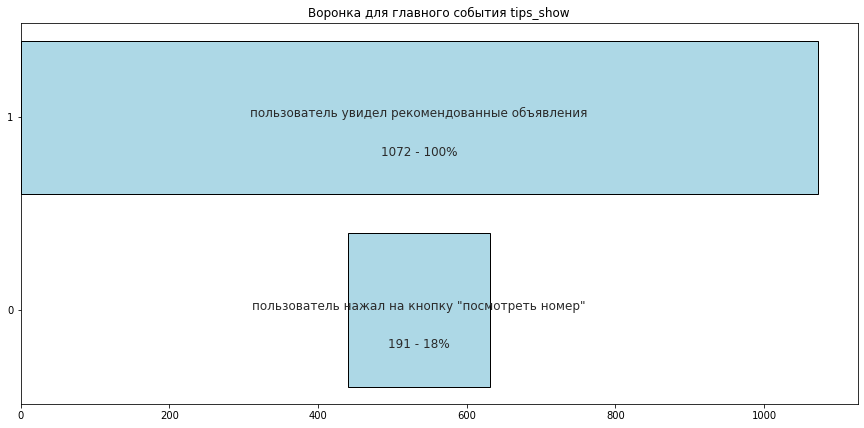

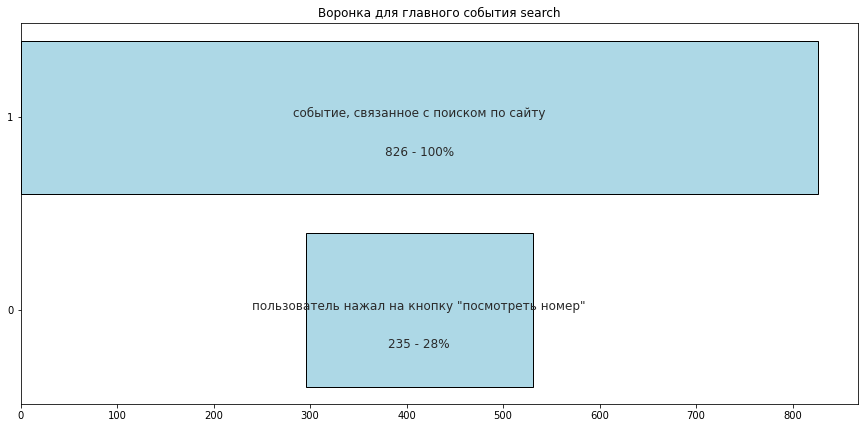

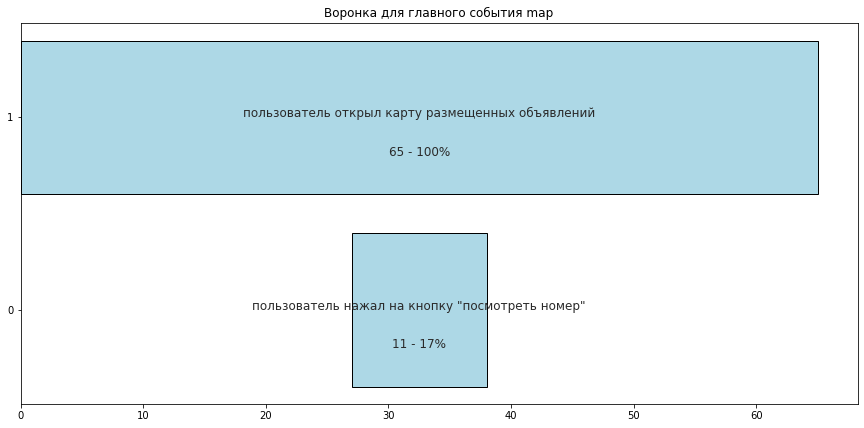

In [34]:
for e in ['tips_show', 'search', 'map']:
    # извлекаю альтернативные события, которые не должны быть у пользователей
    e_nt = [ev for ev  in ['tips_show', 'search', 'map'] if ev!=e]
    # получаем список пользователей, в котором у пользователей есть выбранное событие и нет альтернативных
    # создаю список событий каждого пользователя
    users_df = mobile_df.groupby('user_id', as_index=False).agg({'event_name': 'unique'})
    # проверяю есть ли нужное событие в списке и отсутствует ли альтернативное
    users_df['user_true'] = users_df['event_name'].map(
        lambda e_list: True if e in e_list and set(e_nt).isdisjoint(e_list) else False)
    # выбираю этих пользователей
    users = users_df.query('user_true').user_id
    e_list=[]
    e_list.append(e)
    e_list.append("show_contacts")
    df_filter_user = mobile_df.query('event_name.isin(@e_list) & user_id.isin(@users)')
    tit='Воронка для главного события ' + e
    df_funnel(df_filter_user, tit=tit)

Построила 3 воронки для пользователей, которые либо только видели объявления, либо пользовались поиском, либо смотрели карту объявлений.
<br> Самая хорошая конверсия у тех, кто пользовался поиском.

Больше всего пользователей совершили действие - пользователь увидел рекомендованное объявление.

### Период событий

#### Определить максимальную и минимальную даты

In [35]:
min_date = mobile_df.event_time.min()
max_date = mobile_df.event_time.max()
print(f'В таблице данные за период с {min_date} по {max_date}')

В таблице данные за период с 2019-10-07 00:00:00 по 2019-11-03 23:58:12


#### Построить гистограмму событий по датам

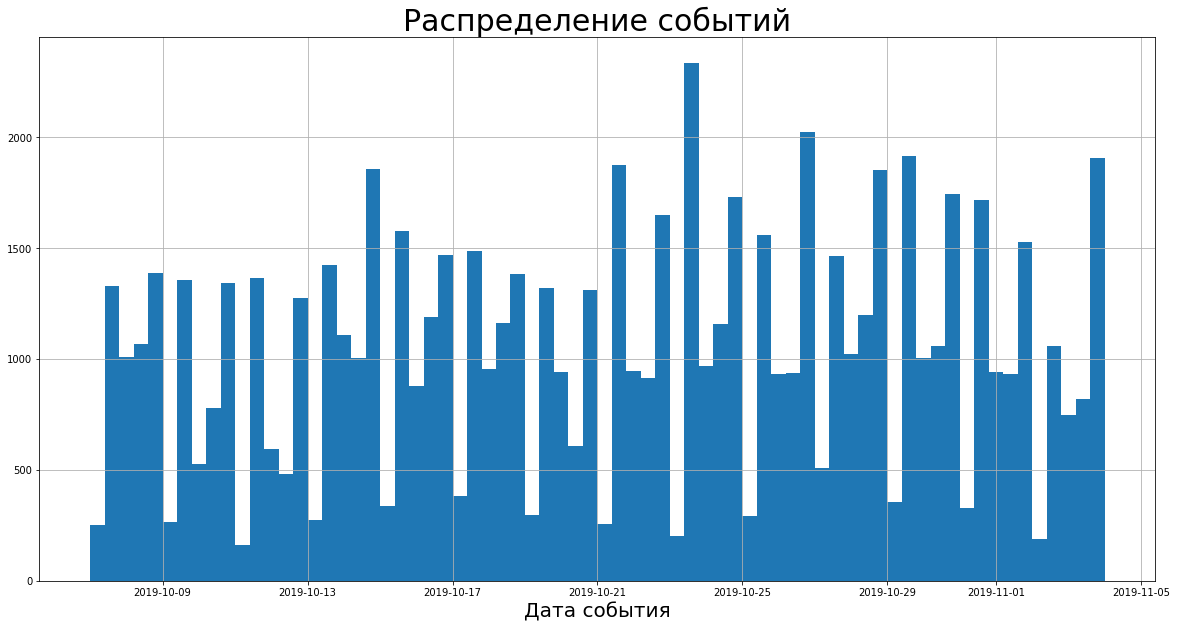

In [36]:
plt.figure(figsize=(20, 10))
mobile_df.event_time.hist(bins=70)
plt.title('Распределение событий', fontsize=30)
plt.xlabel('Дата события', fontsize=20)
plt.show()

На гистограмме нет периода без событий, значит по дате фильтрация не нужна.

#### Посмотреть сколько событий в день в среднем

In [37]:
every_day_mean_event = mobile_df.groupby(['date'], as_index=False).agg({'event_name': 'count'}).event_name.median()
print('Ежедневно в среднем {:.0f} событий'.format(every_day_mean_event))

Ежедневно в среднем 2725 событий


#### Сделать сводную таблицу по пользователям с первой и последней датой, и количество дней в приложении

In [38]:
# таблица с датами приивлечения и оттока пользователей
df_user_date = mobile_df.groupby(['user_id'], as_index=False).agg({'date': ['min', 'max']})
df_user_date.columns = ['user_id', 'first_date', 'last_date']
# добавила столбец с днями проведенном в приложении
df_user_date['days'] = (df_user_date['last_date'] - df_user_date['first_date']).dt.days + 1
df_user_date.head()

,user_id,first_date,last_date,days
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,2019-10-22,16
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19,2019-11-03,16
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01,2019-11-01,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18,2019-10-31,14
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25,2019-10-29,5


#### Оценить сколько пользователей в день приходят ежедневно

In [39]:
every_day_mean_user = df_user_date.groupby('first_date').agg({'user_id': 'count'}).user_id.mean()
print('Ежедневно в среднем приходят {:.0f} уникальных пользователя'.format(every_day_mean_user))

Ежедневно в среднем приходят 153 уникальных пользователя


#### Построить гистограмму пользователей по дням

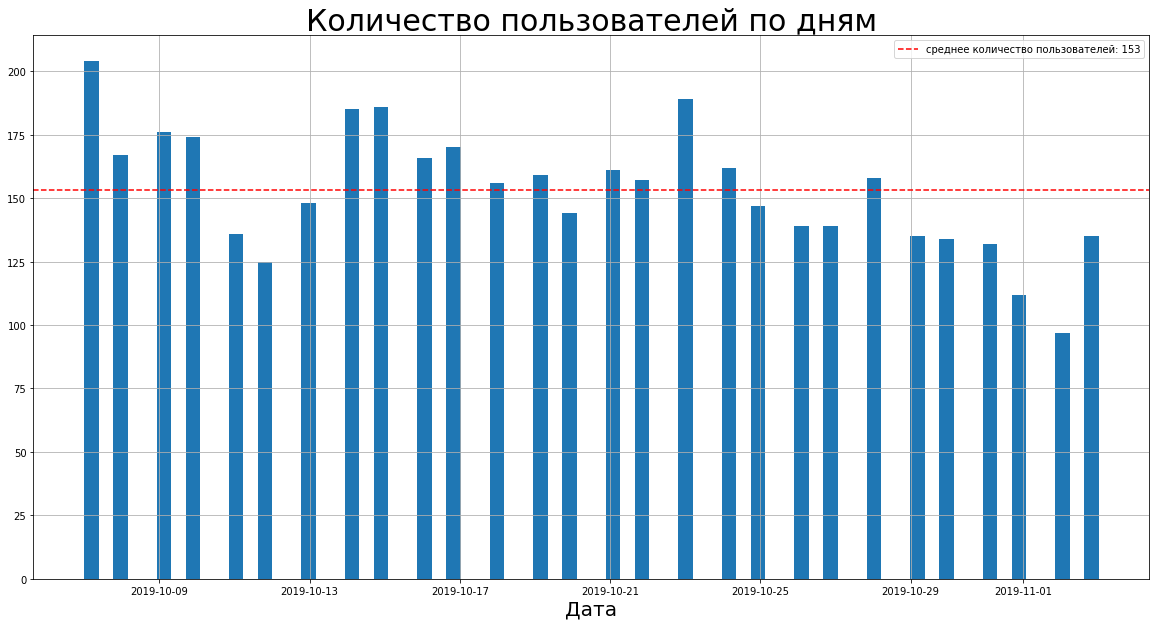

In [40]:
plt.figure(figsize=(20, 10))
df_user_date.first_date.hist(bins=70)
plt.title('Количество пользователей по дням', fontsize=30)
plt.axhline(y=every_day_mean_user, color='r', linestyle='dashed', label='среднее количество пользователей: '+str(round(every_day_mean_user)))
plt.xlabel('Дата', fontsize=20)
plt.legend()
plt.show()

По гистограмме видно, что менее 100 пользователей в день и более 200 - всего по одному деню, остальные дни в этом промежутке.

#### Оценить среднее время проведенное в приложении

In [41]:
print('В среднем пользователь живет {:.0f} день'.format(df_user_date.days.median()))

В среднем пользователь живет 1 день


In [42]:
print('{:.0%} пользователей перестали посещать приложение в день регистрации'.format(
    df_user_date.query('days==1').user_id.nunique()/df_user_date.user_id.nunique()))

64% пользователей перестали посещать приложение в день регистрации


Т е  всего 36% пользователей продолжают пользоваться приложением, может селать пуш-уведомление с рекомендованным объявлением в стиле: "Возможно, Вам это понравится".

### Пользовательские сессии

####  Разделить на пользовательские сессии с учетом 30 минутного интервала

In [43]:
# разделила на пользовательские сессии с учетом 30 минутного интервала
mobile_df['session'] = (mobile_df.groupby(['user_id',pd.Grouper(key='event_time',freq='30min')])
                 .ngroup()+1)

#### Выделить для каждой сессии следующие характеристики:
1. Время начала сессии - start_time
2. Время конца сессии - end_time
3. Длительность сессии в секундах - session_in_s
4. Первое событие - first_event
5. Последнее событие - last_event
6. Список событий - events
7. Количество событий - count_event
8. Есть событие tips_show - have_tips_show
9. Есть событие search - have_search
10. Есть событие map - have_map
11. Есть целевое событие show_contacts - have_show_contacts
12. Частота действий (количество событий в минуту) - frequency

In [44]:
# выделяю характеристики сессий
session_df = mobile_df.groupby(['user_id', 'session'], as_index=False).agg({
    'event_time': ['min', 'max'], 'event_name': ['first', 'last', 'count', 'unique']})
session_df.columns = ['user_id', 'session', 'start_time', 'end_time', 'first_event', 'last_event', 'count_event', 'events']

In [45]:
# время сессии в минутах
session_df['session_time'] = session_df.apply(lambda t: round((t['end_time'].timestamp() - t['start_time'].timestamp())/60,2), axis=1)
session_df['session_time'] = session_df['session_time'].replace(0, 1)

In [46]:
# добавлю столбцы с содержанием главных событий
session_df['have_tips_show'] = session_df['events'].apply(lambda e: True if 'tips_show' in e else False)
session_df['have_show_contacts'] = session_df['events'].apply(lambda e: True if 'show_contacts' in e else False)
session_df['have_search'] = session_df['events'].apply(lambda e: True if 'search' in e else False)
session_df['have_map'] = session_df['events'].apply(lambda e: True if 'map' in e else False)

Частота действий:
<br> $$frequency = \frac{count~event}{session~in~s}$$

In [47]:
session_df['frequency'] = (session_df['count_event']/session_df['session_time']).round(1)

In [48]:
session_df.head()

,user_id,session,start_time,end_time,first_event,last_event,count_event,events,session_time,have_tips_show,have_show_contacts,have_search,have_map,frequency
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45,2019-10-07 13:49:41,tips_show,tips_show,9,[tips_show],9.93,True,False,False,False,0.9
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:33:55,2019-10-09 18:42:22,map,tips_show,4,"[map, tips_show]",8.45,True,False,False,True,0.5
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:52:30,2019-10-21 19:57:49,tips_show,tips_show,8,"[tips_show, map]",5.32,True,False,False,True,1.5
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,2019-10-21 20:00:00,2019-10-21 20:07:30,tips_show,tips_show,6,[tips_show],7.50,True,False,False,False,0.8
4,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,5,2019-10-22 11:18:14,2019-10-22 11:28:05,map,tips_show,6,"[map, tips_show]",9.85,True,False,False,True,0.6


Для каждой сесии получила:
 <br> 1. Время начала сессии - start_time
 <br> 2. Время конца сессии - end_time
 <br> 3. Длительность сессии в минутах - session_time
 <br> 4. Первое событие - first_event
 <br> 5. Последнее событие - last_event
 <br> 6. Список событий - events
 <br> 7. Количество событий - count_event
 <br> 8. Есть событие tips_show - have_tips_show
 <br> 9. Есть событие search - have_search
 <br> 10. Есть событие map - have_map
 <br> 11. Есть целевое событие show_contacts - have_show_contacts
 <br> 12. Частота действий (количество событий в минуту) - frequency

### Источники

In [49]:
mobile_soures.source.unique()

array(['other', 'yandex', 'google'], dtype=object)

#### Посмотреть как соотносятся пользователи по источникам. График

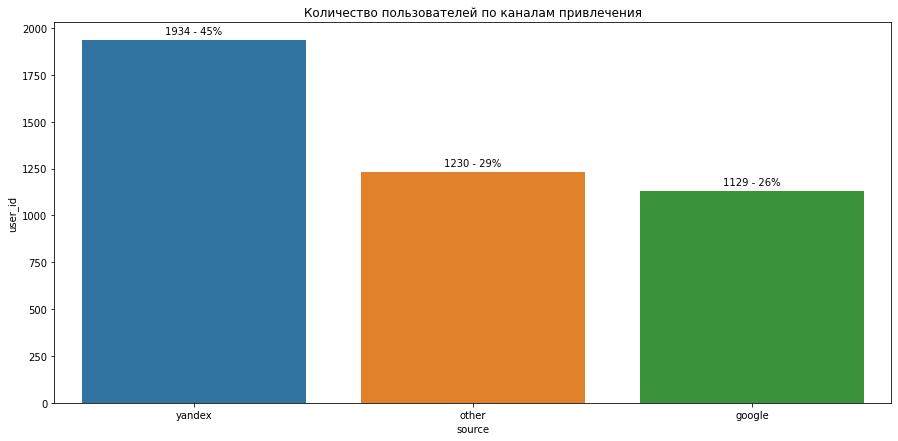

In [50]:
df_bar(mobile_df, 'source', 'user_id', func='nunique', tit='Количество пользователей по каналам привлечения')

Больше всего пользователей из yandex - 45%, из google 26%, остальное пришли из других источников.

#### Посмотреть распределение событий по источникам

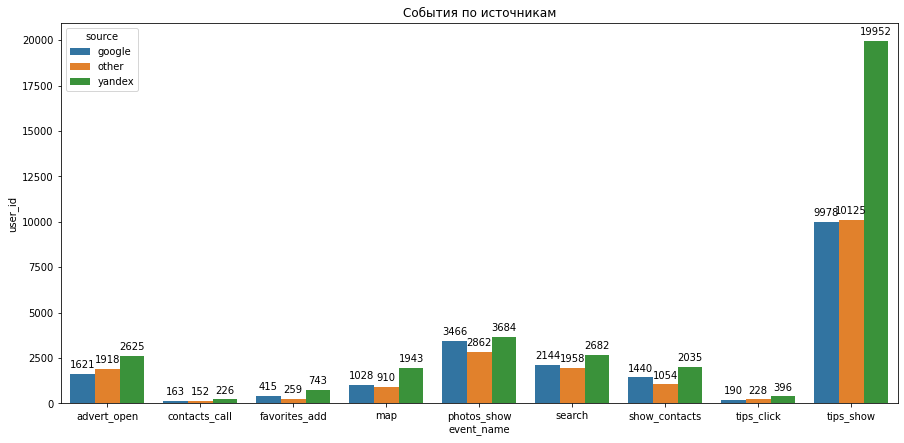

In [51]:
df_bar_source(mobile_df)

Пользователи yandex выбиваются только по показу рекомендованных объявлений, по остальным событиям они примерно на одном уровне. Поэтому подумала, может и конверсия совсем плохая только у yandex.

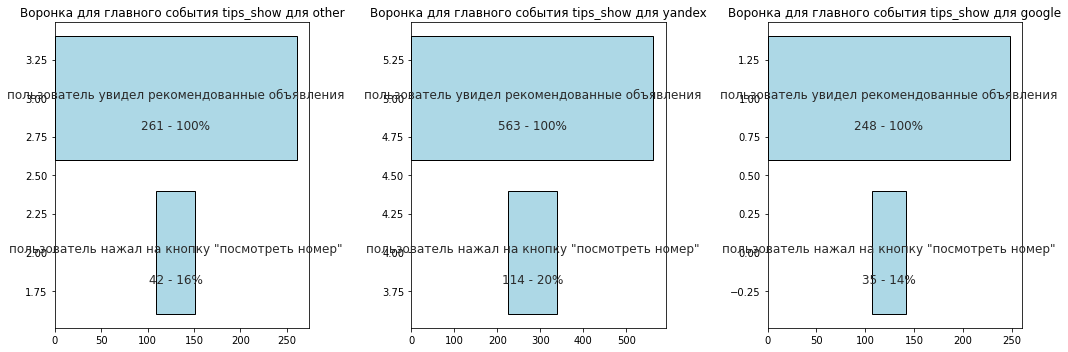

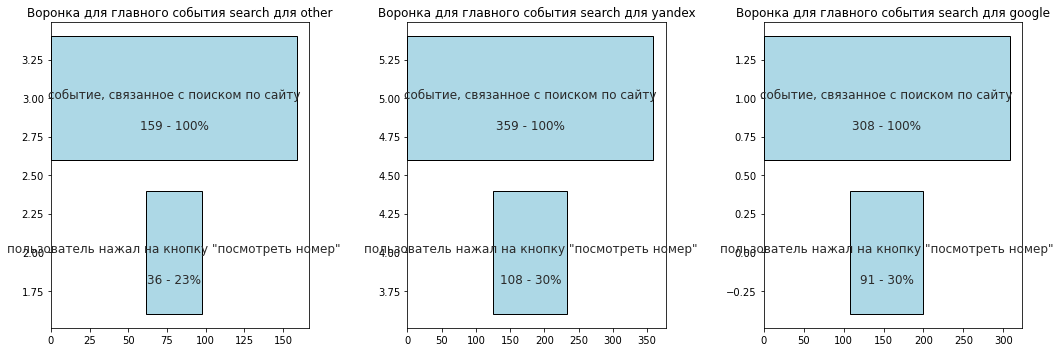

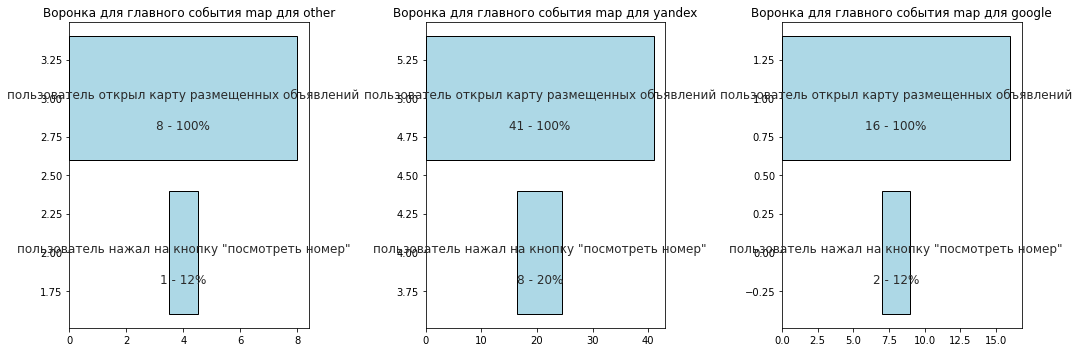

In [52]:
for e in ['tips_show', 'search', 'map']:
    # извлекаю альтернативные события, которые не должны быть у пользователей
    e_nt = [ev for ev  in ['tips_show', 'search', 'map'] if ev!=e]
    # получаем список пользователей, в котором у пользователей есть выбранное событие и нет альтернативных
    # создаю список событий каждого пользователя
    users_df = mobile_df.groupby('user_id', as_index=False).agg({'event_name': 'unique'})
    # проверяю есть ли нужное событие в списке и отсутствует ли альтернативное
    users_df['user_true'] = users_df['event_name'].map(
        lambda e_list: True if e in e_list and set(e_nt).isdisjoint(e_list) else False)
    # выбираю этих пользователей
    users = users_df.query('user_true').user_id
    e_list=["show_contacts"]
    e_list.append(e)
    df_filter_user = mobile_df.query('event_name.isin(@e_list) & user_id.isin(@users)')
    tit='Воронка для главного события ' + e
    df_funnel_source(df_filter_user, tit=tit)

Оказалось, что конверсия из показа рекомендованного объявления в просмотр контактов одинаково плохая для всех источников, хоть и самая многочисленная. Т е пользователям не очень нравятся рекомендованные объявления, может стоит улучшить подбор?
<br> Одинаково хорошая конверсия из поиска, что логично, искал-нашел-забрал.
<br> На втором месте конверсия из просмотра карты объявлений, анамально хорошая у google, но здесь может повлияло, что это самая маленбькая выборка.

### Вывод:
1. В приложении 4293 уникальных пользователей.
2. В датасете 9 событий.
3. Более 50% событий - пользоватнль увидел рекомендованное объявление. На целевое действие - просмотр контактов - приходится всего 6% событий.
4. В среднем на пользователя приходится 17 событий.
5. Не все пользователи видели рекомендованное объявление, некоторые воспользовались поиском, для нахождения объявления.
6. Можно выделить группы событий:
- tips_show и tips_click - рекомендации - первичные действия, которые могут привести к покупке
- search, map - поиск - первичные действия, которые могут привести к покупке
- photos_show, advert_open	- обзор объявлений
- show_contacts, contacts_call	- общение с продавцом - условная покупка
- favorites_add - дополнительные действия
7. Больше всего пользователей совершили действие - пользователь увидел рекомендованное объявление.
8. В таблице данные за период с 2019-10-07 00:00:00 по 2019-11-03 23:58:12.
9. Ежедневно в среднем 2725 событий.
10. Ежедневно в среднем приходят 153 уникальных пользователя.
11. В среднем пользователь живет 1 день, 64% пользователей перестали посещать приложение в день регистрации, т е  всего 36% пользователей продолжают пользоваться приложением, может селать пуш-уведомление с рекомендованным объявлением в стиле: "Возможно, Вам это понравится".
12. Выделенны пользовательские сессии со следующими характеристиками:
- Время начала сессии - start_time
- Время конца сессии - end_time
- Длительность сессии в секундах - session_in_s
- Первое событие - first_event
- Последнее событие - last_event
- Список событий - events
- Количество событий - count_event
- Есть событие tips_show - have_tips_show
- Есть событие search - have_search
- Есть событие map - have_map
- Есть целевое событие show_contacts - have_show_contacts
- Частота действий (количество событий в минуту) - frequency
13. Больше всего пользователей из yandex - 45%, из google 26%, остальное пришли из других источников.
14. Оказалось, что конверсия из показа рекомендованного объявления в просмотр контактов одинаково плохая для всех источников, хоть и самая многочисленная. Т е пользователям не очень нравятся рекомендованные объявления, может стоит улучшить подбор?
<br> Одинаково хорошая конверсия из поиска, что логично, искал-нашел-забрал.
<br> На втором месте конверсия из просмотра карты объявлений, анамально хорошая у google, но здесь может повлияло, что это самая маленбькая выборка.

## Кластеризация пользователей

### Подготовка данных - создание сводной таблицы с группировкой по пользователям и значениями:
1. Сумарное время сессий
2. Среднее время сессий
3. Количество сессиий
4. Число событий
5. Среднее число событий
6. Средняя частота действий

Для кластеризации буду использовать данные сессий.
Хотела добавить только столбец с источником данных, но после кластеризации выяснила, что он никак не участвовал в разделении пользователей, поэтому решила не брать его.
<br> Сначала найду количество групп с помощью агломеративной иерархической кластеризации по дендрограмме.
<br> Затем сделаю кластеризацию с помощью K-Means.

In [53]:
df_group_user = session_df.groupby('user_id', as_index=False).agg({
                                                                    'session_time': ['sum', 'mean'],
                                                                    'session': 'count',
                                                                    'count_event': ['sum', 'mean'],
                                                                    'frequency': 'mean',
                                                                    'have_tips_show': 'sum',
                                                                    'have_show_contacts': 'sum',
                                                                    'have_search': 'sum',
                                                                    'have_map': 'sum',
                                                                  })
df_group_user.columns = ['user_id', 'sum_time_session', 'mean_time_session', 'count_session', 'count_event', 
                         'mean_event', 'frequency', 'sum_tips_show', 'sum_show_contacts', 'sum_search', 'sum_map']

df_group_user.head()

,user_id,sum_time_session,mean_time_session,count_session,count_event,mean_event,frequency,sum_tips_show,sum_show_contacts,sum_search,sum_map
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,41.83,6.971667,6,35,5.833333,1.150000,6,0,0,3
1,00157779-810c-4498-9e05-a1e9e3cedf93,170.35,14.195833,12,71,5.916667,0.733333,0,8,7,0
2,00463033-5717-4bf1-91b4-09183923b9df,21.23,10.615000,2,10,5.000000,0.650000,0,0,0,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,58.98,6.553333,9,32,3.555556,2.488889,2,0,7,4
4,00551e79-152e-4441-9cf7-565d7eb04090,10.32,3.440000,3,8,2.666667,13.833333,0,2,1,0


Для каждого пользователя нашла:
- Сумарное время сессий
- Среднее время сессий
- Количество сессиий
- Число событий
- Среднее число событий
- Средняя частота действий
- Суммарное количество действий для расчета конверсии

#### Рассчет конверсии в целевое действие 

In [54]:
# рассчитаю конверсию в целевое действие
df_group_user['conversion_from_tips_show'] = df_group_user.apply(lambda r: r['sum_show_contacts']/r['sum_tips_show'] 
                                                                 if r['sum_tips_show']!=0 else 0, axis=1)
df_group_user['conversion_from_search'] = df_group_user.apply(lambda r: r['sum_show_contacts']/r['sum_search'] 
                                                                 if r['sum_search']!=0 else 0, axis=1)
df_group_user['conversion_from_map'] = df_group_user.apply(lambda r: r['sum_show_contacts']/r['sum_map'] 
                                                                 if r['sum_map']!=0 else 0, axis=1)

#### Удалю лишние столбцы

In [55]:
df_group_user.drop(['sum_show_contacts', 'sum_tips_show', 'sum_search', 'sum_map', 'sum_time_session', 'count_event'], inplace=True, axis=1)

#### Стандартизизация данных

In [56]:
sc = StandardScaler()
X_sc = sc.fit_transform(df_group_user.drop(['user_id'], axis=1))

### Матрица расстояний и дендрограмма для рассчета количества групп

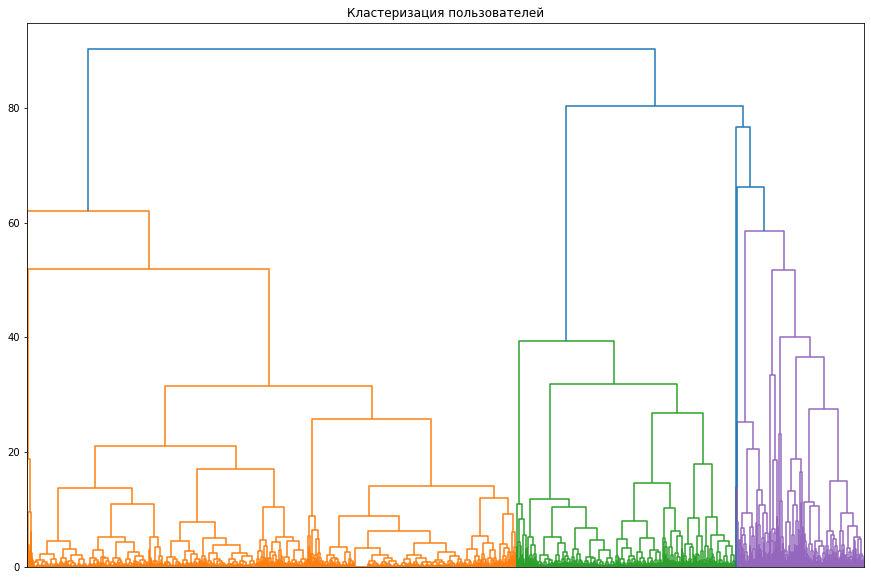

In [57]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей')
plt.xticks([]) #убрала подписи признаков, т к это сплошная полоса и даде наклоном их не разделить
plt.show() 

Предложенно оптимальное число кластеров 3.

### Модель кластеризации на основании алгоритма K-Means 

In [58]:
# задаём модель k_means с числом кластеров 3 и фиксируем значение random_state
km = KMeans(n_clusters=3, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)
# сохраняем метки кластера в поле нашего датасета
df_group_user['cluster_km'] = labels

### Пользователи по кластерам

#### Статистика по средним значениям наших признаков по кластеру

In [59]:
# выводим статистику по средним значениям наших признаков по кластеру
cluster_mean = df_group_user.groupby(['cluster_km']).mean().round().reset_index()
cluster_mean

,cluster_km,mean_time_session,count_session,mean_event,frequency,conversion_from_tips_show,conversion_from_search,conversion_from_map
0,0,9.0,7.0,7.0,2.0,1.0,1.0,1.0
1,1,4.0,3.0,4.0,3.0,0.0,0.0,0.0
2,2,13.0,3.0,9.0,1.0,0.0,0.0,0.0


0 кластер:
<br>Много сессий средней продолжительности со средним количеством событий и высокой конверсией в целевое действие (пользователи и переходят по рекомендованному объявлению и сами находят объявления) - средняя скорость - много быстро ищут и находят.
<br>1 кластер:
<br>Мало коротких сессий с маленьким количеством событий и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят) - самые долгие - мало быстро просматривают объявления, но ничего не выбирают.
<br>2 кластер:
<br>Мало долгих сессий с большим количеством событий и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят) - самые быстрые - долго изучают, но мало выбирают.

#### Соотношение групп по пользователям

In [60]:
cluster_mean = cluster_mean.merge(df_group_user.groupby(['cluster_km'], as_index=False).user_id.count().rename(columns={'user_id': 'count_users'}), on='cluster_km')
cluster_mean

,cluster_km,mean_time_session,count_session,mean_event,frequency,conversion_from_tips_show,conversion_from_search,conversion_from_map,count_users
0,0,9.0,7.0,7.0,2.0,1.0,1.0,1.0,298
1,1,4.0,3.0,4.0,3.0,0.0,0.0,0.0,2785
2,2,13.0,3.0,9.0,1.0,0.0,0.0,0.0,1210


Меньше всего пользователей 0 кластера, которые быстро находят и выбирают.
<br> Самый многочисленые кластер 1, пользователи которого быстро посмотрели и ничего не нашли.
<br> Средний по количеству 2 кластер, пользователи которого долго ищут, но ничего не выбирают.

#### Отрисовка графиков с разделением по кластерам

In [61]:
col_pairs = df_group_user.drop(['user_id', 'cluster_km'], axis=1).columns

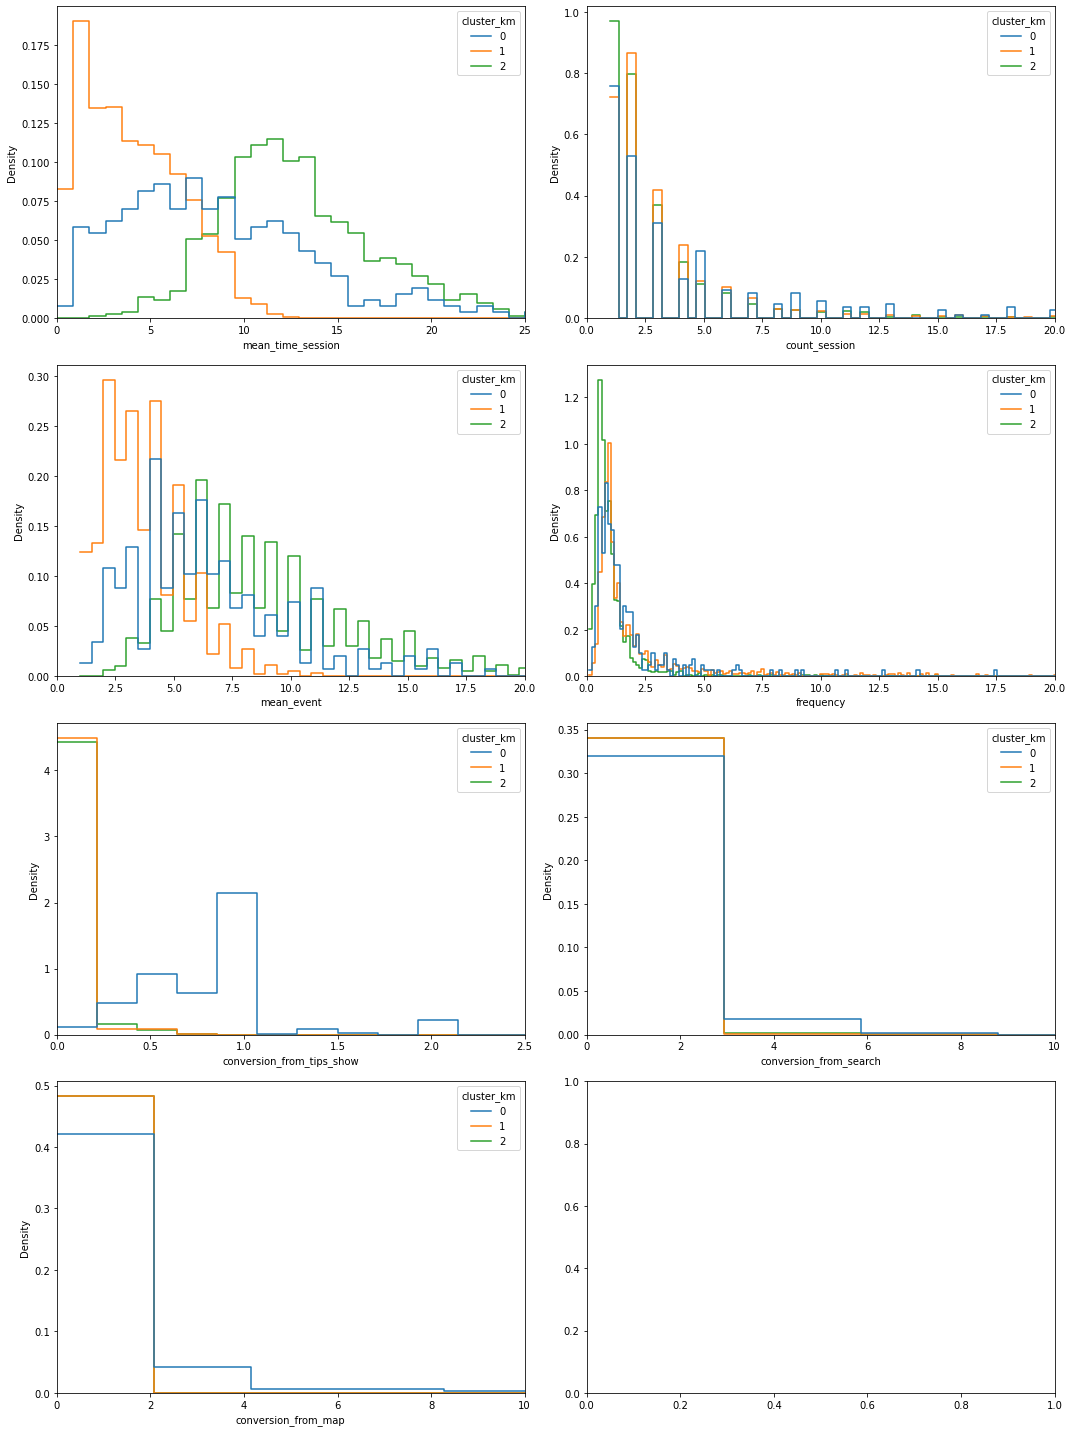

In [62]:
fig, axes = plt.subplots(nrows=len(col_pairs)//2+1, ncols=2, figsize=(15, 20))
xlim = [(0, 25), (0, 20), (0, 20), (0, 20), (0, 2.5), (0, 10), (0, 10)]
for i, pair in enumerate(col_pairs):
    ax_i = axes[i//2, i%2]
    sns.histplot(data=df_group_user, x=pair, hue="cluster_km", element="step", stat="density", common_norm=False, 
                fill=False, palette='tab10', ax=ax_i, legend=True)
    ax_i.set_xlim(xlim[i])
fig.tight_layout()
plt.show()

0 кластер:
<br>Много сессий (есть пользователи у которых больше 40) средней продолжительности (от 5 до 10 минут) со средним количеством событий (от 2 до 8) и высокой конверсией в целевое действие (пользователи и переходят по рекомендованному объявлению и сами находят объявления) с частотой переходов (от 0 до 2,5 событий в минуту, есть очень быстрые переходы) - много быстро ищут и находят.
<br>1 кластер:
<br>Мало (до 15 сессий) коротких ( от 0 до 5 минут, нет больше 10 минут) сессий с маленьким количеством событий ( от 0 до 5, нет больше 10) и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят)  с частотой переходов (от 0 до 2,5 событий в минуту, есть очень быстрые переходы) - мало быстро просматривают объявления, но ничего не выбирают.
<br>2 кластер:
<br>Мало (до 10 сессий) долгих (от 10 до 15 минут) сессий с большим количеством событий (в основном от 5 до 8, но есть и больше) и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят) с частотой переходов (от 0 до 2,5 событий в минуту) - долго изучают, но мало выбирают.

#### Описание пользовательских групп

0 кластер:
<br>Меньше всего пользователей, много сессий (есть пользователи у которых больше 40) средней продолжительности (от 5 до 10 минут) со средним количеством событий (от 2 до 8) и высокой конверсией в целевое действие (пользователи и переходят по рекомендованному объявлению и сами находят объявления) со средней частотой переходов (от 0 до 2,5 событий в минуту, есть очень быстрые переходы) - много быстро ищут и находят.
<br>1 кластер:
<br>Больше всего пользователей, мало (до 15 сессий) коротких ( от 0 до 5 минут, нет больше 10 минут) сессий с маленьким количеством событий ( от 0 до 5, нет больше 10) и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят)  с самой большой частотой переходов (от 0 до 2,5 событий в минуту, есть очень быстрые переходы) - мало быстро просматривают объявления, но ничего не выбирают.
<br>2 кластер:
<br>Средний по количеству кластер, мало (до 10 сессий) долгих (от 10 до 15 минут) сессий с большим количеством событий (в основном от 5 до 8, но есть и больше) и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят) с самой короткой частотой переходов (от 0 до 2,5 событий в минуту) - долго изучают, но мало выбирают.

### Сравнение пользовательских групп по метрикам:
- retention rate (разделение на когорты по неделям)
- время, проведенное в приложении
- частот действий
- конверсия в целевое действие (просмотр контактов)

Все метрики, кроме retention rate я учла при разделении пользователей и описала в портрете пользователя по кластерам, поэтому рассчитаю retention rate и посмотрю на него.

#### Оценка retention rate

##### Добавление даты первого посещения

##### Выделение лайфтайма

In [63]:
mobile_df = mobile_df.merge(df_user_date[['user_id', 'first_date']], on='user_id')

In [64]:
mobile_df['lifetime'] = ((mobile_df['date'] - mobile_df['first_date']).dt.days)//7

##### Добавление номера кластера

In [65]:
mobile_df = mobile_df.merge(df_group_user[['user_id', 'cluster_km']], on='user_id')

##### Разделение на отдельные датасеты по кластерам

In [66]:
cluster_0 = mobile_df.query('cluster_km==0')
cluster_1 = mobile_df.query('cluster_km==1')
cluster_2 = mobile_df.query('cluster_km==2')

##### Расчет retention rate и визуализация

<br> $$Retention~Rate = \frac{Количество~пользователей~на~текущий~день}{Количество~пользователей~на~1~день}$$

In [67]:
dict_claster = {'cluster_0': cluster_0,
                'cluster_1': cluster_1,
                'cluster_2': cluster_2}

Тепловая карта и кривые удержания для cluster_0


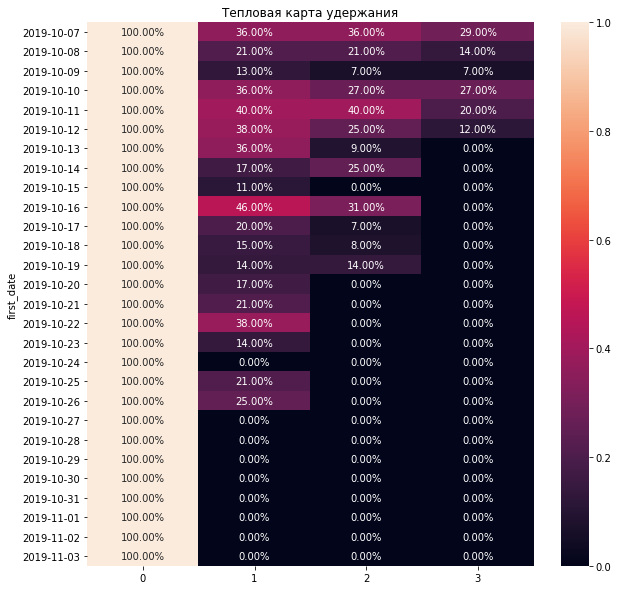

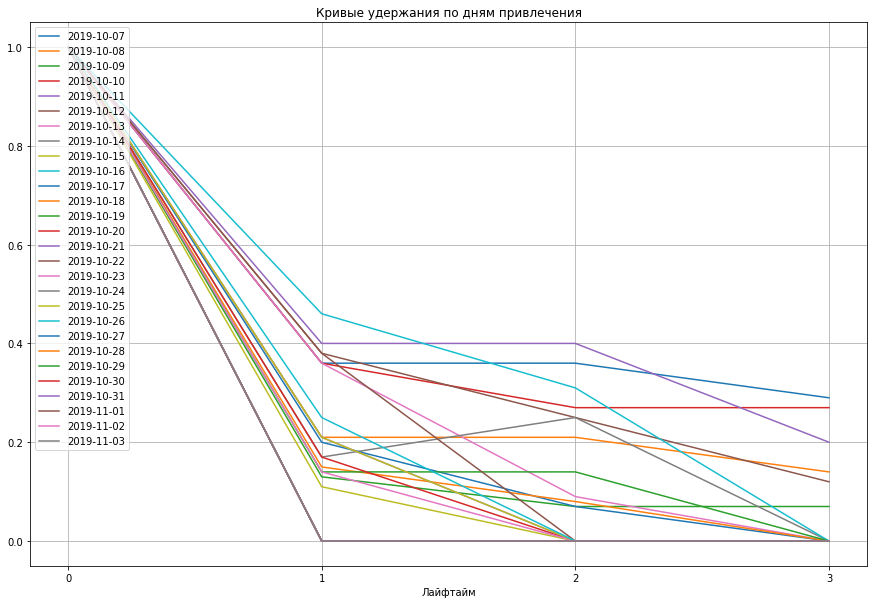


Тепловая карта и кривые удержания для cluster_1


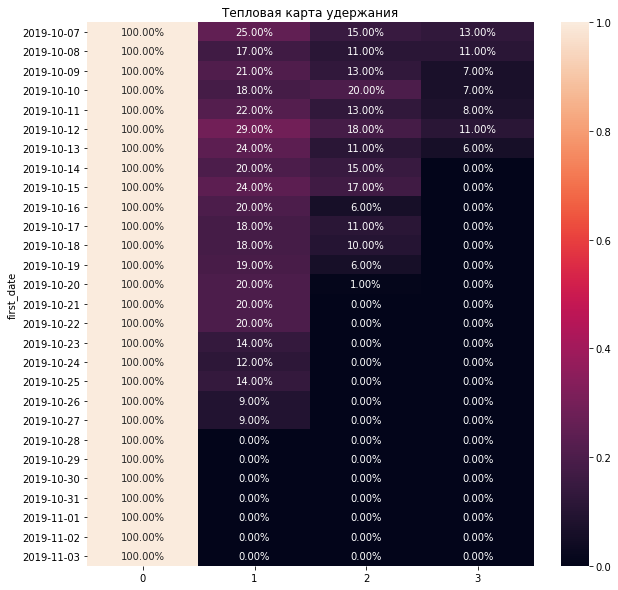

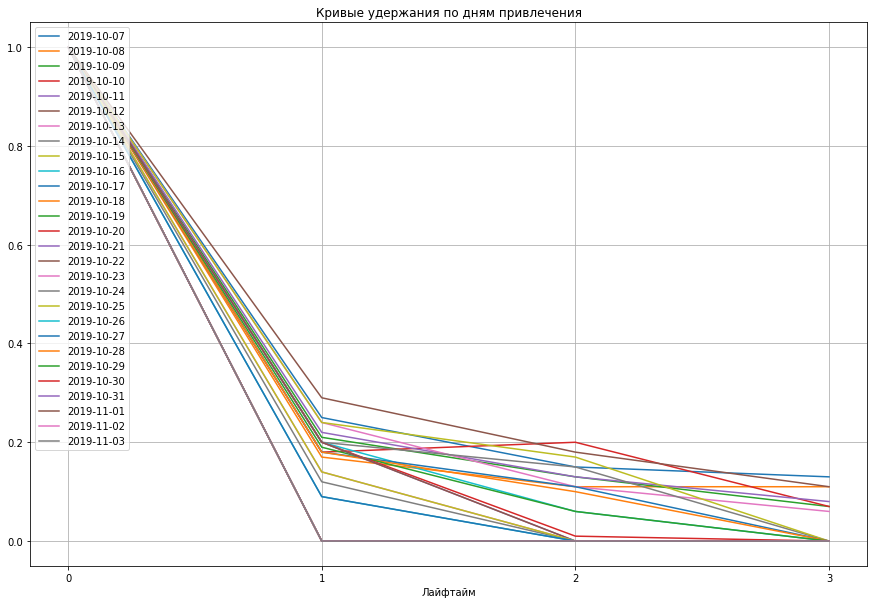


Тепловая карта и кривые удержания для cluster_2


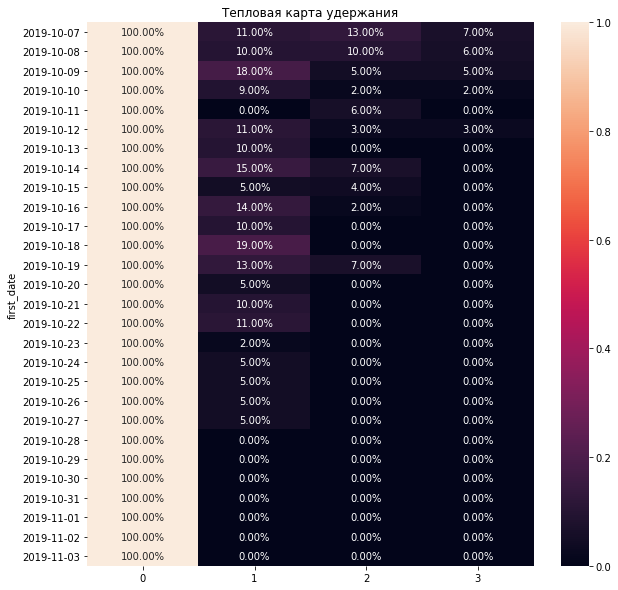

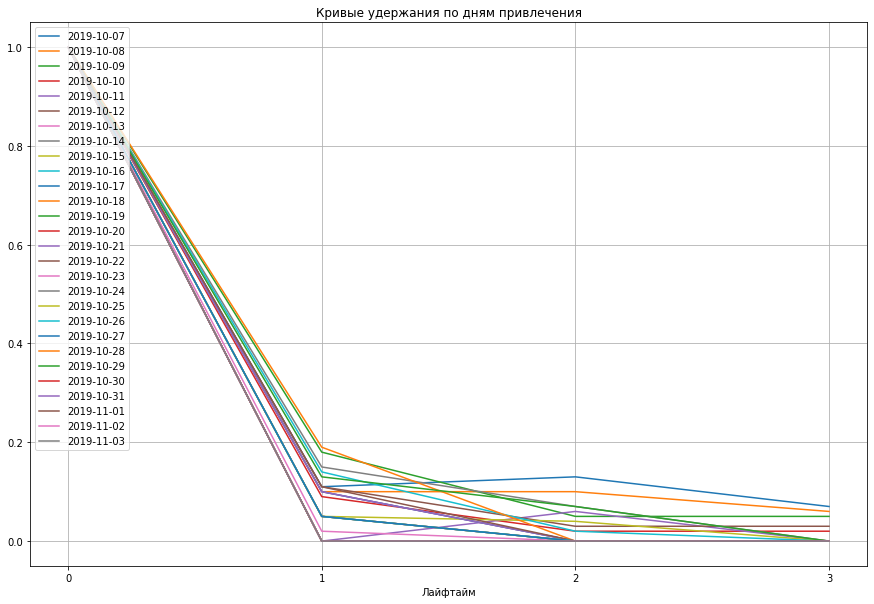

In [68]:
df_ret= pd.DataFrame()
for rr in ['cluster_0', 'cluster_1', 'cluster_2']:
    ret_r, sum_ret_r =  retention_rate(dict_claster[rr])
    s = pd.Series(data=sum_ret_r, name=rr)
    df_ret = df_ret.append(s)
    print('Тепловая карта и кривые удержания для '+ rr)
    show_heatmap(ret_r)
    show_plot(ret_r)
    print()

Таблица суммарного retention rate по лайфтаймам и кластерам

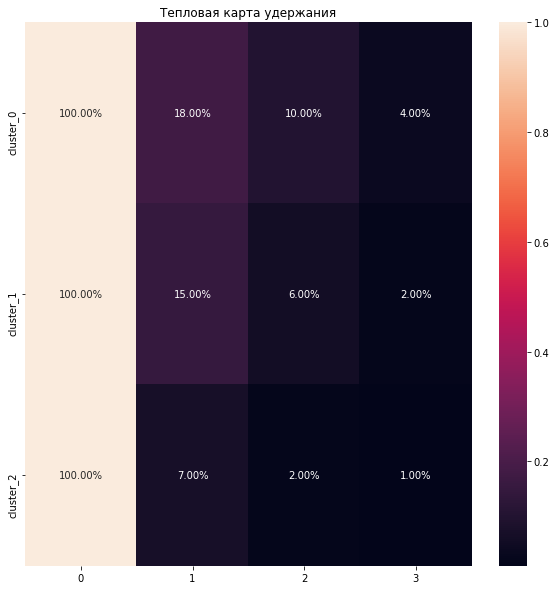

In [69]:
show_heatmap(df_ret)

In [70]:
df_ret=df_ret.reset_index(drop=False).drop('index', axis=1).reset_index(drop=False).rename(columns={'index':'cluster_km'})
df_ret

,cluster_km,0,1,2,3
0,0,1.0,0.18,0.10,0.04
1,1,1.0,0.15,0.06,0.02
2,2,1.0,0.07,0.02,0.01


Добавлю в таблицу средних

In [71]:
cluster_mean = cluster_mean.merge(df_ret, on='cluster_km')
cluster_mean

,cluster_km,mean_time_session,count_session,mean_event,frequency,conversion_from_tips_show,conversion_from_search,conversion_from_map,count_users,0,1,2,3
0,0,9.0,7.0,7.0,2.0,1.0,1.0,1.0,298,1.0,0.18,0.10,0.04
1,1,4.0,3.0,4.0,3.0,0.0,0.0,0.0,2785,1.0,0.15,0.06,0.02
2,2,13.0,3.0,9.0,1.0,0.0,0.0,0.0,1210,1.0,0.07,0.02,0.01


- 0 кластер:
<br> Удерживаются лучше всех. На второй неделе остаются 18%, на четвертой - 4%.
- 1 кластер:
<br> Удерживаются чуть хуже. На второй неделе остаются 15%, на четвертой - 2%.
- 2 кластер:
<br> Удерживаются хуже всех. На второй неделе остаются всего 7%, на четвертой - 1%.

Первый кластер похож на тех, кто занимается покупкой и продажей веще почти "профессионально". У нашего приложения retention 4 недели.
 <br>Это не очень хорошо, я смотрела и по дням, там тоже все не очень хорошо, т к большинство отсеивается в первый же день.
 <br> Здесь точно стоит подумать над тем, как улучшить приложение, сделать более удобным. Можно сделать опрос для целевой аудитории, и уже по нему понять.

### Вывод:
1. Для кластеризации использую следующие признаки для каждого пользователя:
- Среднее время сессий
- Количество сессиий
- Среднее число событий
- Средняя частота действий
- Конверсия в целевое действие
2. По дендрограмме предложенно оптимальное число кластеров 3, поэтому с помощью алгоритма K-Means я разделила на 3 кластера.
3. Описание групп пользователей:
- 0 кластер:
<br>Меньше всего пользователей, много сессий (есть пользователи у которых больше 40) средней продолжительности (от 5 до 10 минут) со средним количеством событий (от 2 до 8) и высокой конверсией в целевое действие (пользователи и переходят по рекомендованному объявлению и сами находят объявления) со средней частотой переходов (от 0 до 2,5 событий в минуту, есть очень быстрые переходы) - много быстро ищут и находят.  Удерживаются лучше всех. На второй неделе остаются 18%, на четвертой - 4%.
<br> **0 кластер - целевая аудитория**
- 1 кластер:
<br>Больше всего пользователей, мало (до 15 сессий) коротких ( от 0 до 5 минут, нет больше 10 минут) сессий с маленьким количеством событий ( от 0 до 5, нет больше 10) и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят)  с самой большой частотой переходов (от 0 до 2,5 событий в минуту, есть очень быстрые переходы) - мало быстро просматривают объявления, но ничего не выбирают. Удерживаются чуть хуже. На второй неделе остаются 15%, на четвертой - 2%.
- 2 кластер:
<br>Средний по количеству кластер, мало (до 10 сессий) долгих (от 10 до 15 минут) сессий с большим количеством событий (в основном от 5 до 8, но есть и больше) и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят) с самой короткой частотой переходов (от 0 до 2,5 событий в минуту) - долго изучают, но мало выбирают. Удерживаются хуже всех. На второй неделе остаются всего 7%, на четвертой - 1%.

## Проверка гипотез

Для проверки стат различий буду использовать Проверку гипотез о равенстве долей
<br>Если некоторая доля генеральной совокупности обладает признаком, а другая её часть — нет, об этой доле можно судить по выборке из генеральной совокупности. Выборочные доли будут нормально распределены вокруг настоящей (по центральной предельной теореме).
<br>Разница между конверсиями, наблюдаемыми на группах, будет нашей статистикой. Так называется переменная, значения которой рассчитываются только по выборочным данным - переменная Z.

Формула Z:
$$Z = \frac{(P1-P2)-(pi1-pi2)}{\sqrt{P(1-P)*{({1}{/n1}+{1}{/n2})}}}$$

### 1 Гипотеза:
<br>Некоторые пользователи установили приложение по ссылке из yandex, другие — из google.
<br>Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов.
<br>Нулевая гипотеза:
<br>Конверсия в целевое действие пользователей, привлеченных google и yandex равна
<br>Альтернативная гипотеза:
<br>Конверсия в целевое действие пользователей, привлеченных google и yandex различна

In [72]:
stat_rez(mobile_df, group=['google', 'yandex'])


Таблица конверсии


,conversion,event_down,event_top
google:show_contacts/tips_show,0.42,275.0,651.0
yandex:show_contacts/tips_show,0.36,478.0,1310.0


p-значение: 0.0101
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница


### 2 Гипотеза:
<br>Заметила, что есть пользователи, которые перешли к объявлению через рекомендованное объявление и пользователи, которые сами искали объявления через поиск.
<br>Гипотеза: две эти группы демонстрируют разную конверсию в просмотры контактов.
<br>Нулевая гипотеза:
<br>Конверсия в целевое действие пользователей, пользователей, которые перешли к объявлению через рекомендованное объявление и пользователей, которые сами искали объявления через поиск, равна
<br>Альтернативная гипотеза:
<br>Конверсия в целевое действие пользователей, пользователей, которые перешли к объявлению через рекомендованное объявление и пользователей, которые сами искали объявления через поиск, различна

In [73]:
stat_rez(mobile_df, evnt_top=['tips_show', 'search'], evnt_down=['show_contacts', 'show_contacts'])


Таблица конверсии


,conversion,event_down,event_top
show_contacts/tips_show,0.18,516.0,2801.0
show_contacts/search,0.23,377.0,1666.0


p-значение: 0.0001
Отвергаем нулевую гипотезу: между конверсиями есть значимая разница


### Вывод:
1. p-значение: 0.0101, поэтому отвергаем нулевую гипотезу о том, что конверсия в целевое действие пользователей, привлеченных google и yandex равна.
2. p-значение: 0.0001, поэтому отвергаем нулевую гипотезу о том, что  в целевое действие пользователей, которые перешли к объявлению через рекомендованное объявление и пользователей, которые сами искали объявления через поиск, равна.

## Общий вывод
1. В приложении 4293 уникальных пользователей.
2. В датасете 9 событий.
3. Более 50% событий - пользователь увидел рекомендованное объявление. На целевое действие - просмотр контактов - приходится всего 6% событий.
4. В среднем на пользователя приходится 17 событий.
5. Не все пользователи видели рекомендованное объявление, некоторые воспользовались поиском, для нахождения объявления.
6. Можно выделить группы событий:
- tips_show и tips_click - рекомендации - первичные действия, которые могут привести к покупке
- search, map - поиск - первичные действия, которые могут привести к покупке
- photos_show, advert_open	- обзор объявлений
- show_contacts, contacts_call	- общение с продавцом - условная покупка
- favorites_add - дополнительные действия
<br> Для воронки выбраны события: tips_show, search, map -> photos_show, advert_open -> show_contacts
7. По воронке видно, что больше всего пользователей совершили действие - пользователь увидел рекомендованное объявление. Целевое действие - просмотр контактов - 35% от тех, кто увидел рекомендованное объявление.
8. В таблице данные за период с 2019-10-07 00:00:00 по 2019-11-03 23:58:12.
9. Ежедневно в среднем 2725 событий.
10. Ежедневно в среднем приходят 153 уникальных пользователя.
11. В среднем пользователь живет 1 день, 64% пользователей перестали посещать приложение в день регистрации, т е  всего 36% пользователей продолжают пользоваться приложением, может сделать пуш-уведомление с рекомендованным объявлением в стиле: "Возможно, Вам это понравится".
12. Выделенны пользовательские сессии со следующими характеристиками:
- Время начала сессии - start_time
- Время конца сессии - end_time
- Длительность сессии в секундах - session_in_s
- Первое событие - first_event
- Последнее событие - last_event
- Список событий - events
- Количество событий - count_event
- Есть событие tips_show - have_tips_show
- Есть событие search - have_search
- Есть событие map - have_map
- Есть целевое событие show_contacts - have_show_contacts
- Частота действий (количество событий в минуту) - frequency
13. Больше всего пользователей из yandex - 45%, из google 26%, остальное пришли из других источников.
14. Оказалось, что конверсия из показа рекомендованного объявления в просмотр контактов одинаково плохая для всех источников, хоть и самая многочисленная. Т е пользователи не очень нравится рекомендованные объявления, может стоит улучшить подбор?
<br> Одинаково хорошая конверсия из поиска, что логично, искал-нашел-забрал.
<br> На втором месте конверсия из просмотра карты объявлений, анамально хорошая у google, но здесь может повлияло, что это самая маленбькая выборка.
15. Для кластеризации использую следующие признаки для каждого пользователя:
- Среднее время сессий
- Количество сессиий
- Среднее число событий
- Средняя частота действий
- Конверсия в целевое действие
16. По дендрограмме предложенно оптимальное число кластеров 3, поэтому с помощью алгоритма K-Means я разделила на 3 кластера.
17. Описание групп пользователей:
- 0 кластер:
<br>Меньше всего пользователей, много сессий (есть пользователи у которых больше 40) средней продолжительности (от 5 до 10 минут) со средним количеством событий (от 2 до 8) и высокой конверсией в целевое действие (пользователи и переходят по рекомендованному объявлению и сами находят объявления) со средней частотой переходов (от 0 до 2,5 событий в минуту, есть очень быстрые переходы) - много быстро ищут и находят.  Удерживаются лучше всех. На второй неделе остаются 18%, на четвертой - 4%.
- 1 кластер:
<br>Больше всего пользователей, мало (до 15 сессий) коротких ( от 0 до 5 минут, нет больше 10 минут) сессий с маленьким количеством событий ( от 0 до 5, нет больше 10) и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят)  с самой большой частотой переходов (от 0 до 2,5 событий в минуту, есть очень быстрые переходы) - мало быстро просматривают объявления, но ничего не выбирают. Удерживаются чуть хуже. На второй неделе остаются 15%, на четвертой - 2%.
- 2 кластер:
<br>Средний по количеству кластер, мало (до 10 сессий) долгих (от 10 до 15 минут) сессий с большим количеством событий (в основном от 5 до 8, но есть и больше) и низкой конверсией в целевое действие (пользователи плохо переходят по рекомендованному объявлению и сами ничего не находят) с самой короткой частотой переходов (от 0 до 2,5 событий в минуту) - долго изучают, но мало выбирают. Удерживаются хуже всех. На второй неделе остаются всего 7%, на четвертой - 1%.
18. **0 кластер - целевая аудитория** - лучше всех удерживаются и самая хорошая конверсия в целевое событие
19. Проведена проверка гипотез. По результатам проверки:
- p-значение: 0.0101, поэтому отвергаем нулевую гипотезу о том, что конверсия в целевое действие пользователей, привлеченных google и yandex равна.
- p-значение: 0.0001, поэтому отвергаем нулевую гипотезу о том, что конверсия в целевое действие пользователей, которые перешли к объявлению через рекомендованное объявление и пользователей, которые сами искали объявления через поиск, равна.
20. **Рекомендации**
<br> Из-за низкого retention rate
- Сделать пуш-уведомление с предложением "Вам может это понравится"
- Провести опрос целевой аудитории по улучшению приложения
<br> Из-за низкой конверсии из рекомендованного объявления в просмотр контактов
- Улучшить алгоритм подбора объявлений